In [5]:
import os
import sys
import torch
import torch.nn as nn
import timm
from tqdm.notebook import tqdm
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) 

from fine_tuning_proj.config import GlobalConfig, DataConfig, ModelConfig, TrainConfig
from fine_tuning_proj.utils import set_seed
from fine_tuning_proj.dataset import get_transforms, get_dataloaders
from fine_tuning_proj.plots import plot_learning_curves, plot_confusion_matrix

set_seed(GlobalConfig.SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data_cfg = DataConfig()
model_cfg = ModelConfig()
train_cfg = TrainConfig()

print(f"Устройство: {DEVICE}, Сид зафиксирован: {GlobalConfig.SEED}")
print(f"Классы: {data_cfg.NUM_CLASSES}")

Устройство: cpu, Сид зафиксирован: 42
Классы: 3


In [6]:
# 1. Получение трансформаций (train с аугментацией, val/test без)
train_transforms, val_test_transforms = get_transforms(data_cfg)

# 2. Создание DataLoader'ов
train_loader, val_loader, test_loader = get_dataloaders(
    data_cfg, 
    train_transforms, 
    val_test_transforms, 
    train_cfg.BATCH_SIZE
)

class_names = train_loader.dataset.classes
print(f"Имена классов, считанные из папок: {class_names}")
print(f"Размер обучающей выборки: {len(train_loader.dataset)}")
print(f"Размер валидационной выборки: {len(val_loader.dataset)}")
print(f"Размер тестовой выборки: {len(test_loader.dataset)}")

Имена классов, считанные из папок: ['Lily', 'Orchid', 'Peony']
Размер обучающей выборки: 66
Размер валидационной выборки: 12
Размер тестовой выборки: 12


In [7]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Выполняет один проход обучения."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate_model(model, dataloader, device):
    """Оценивает модель на валидационной/тестовой выборке."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    all_labels = []
    all_preds = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            
            correct_predictions += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item(), np.array(all_labels), np.array(all_preds)

In [8]:
# Инициализация ResNet18
model_name_cnn = model_cfg.MODEL_1_NAME
model_cnn = timm.create_model(model_name_cnn, pretrained=True)

# Адаптация Head 
num_ftrs = model_cnn.fc.in_features
model_cnn.fc = nn.Linear(num_ftrs, data_cfg.NUM_CLASSES)
model_cnn = model_cnn.to(DEVICE)

# Сначала замораживаем все веса
print("--- Стратегия Fine-Tuning для ResNet18 ---")
for param in model_cnn.parameters():
    param.requires_grad = False
    
# Размораживаем только классификационный Head ('fc' слой) для первого этапа обучения
for param in model_cnn.fc.parameters():
    param.requires_grad = True

print("Этап 1: Заморожен Body, обучается только Head (fc layer).")

--- Стратегия Fine-Tuning для ResNet18 ---
Этап 1: Заморожен Body, обучается только Head (fc layer).


Training resnet18:   7%|▋         | 1/15 [00:20<04:43, 20.26s/it]

Эпоха 1: Train Loss=1.1140, Val Loss=1.1146, Val Acc=0.1667


Training resnet18:  13%|█▎        | 2/15 [00:40<04:25, 20.42s/it]

Эпоха 2: Train Loss=1.1074, Val Loss=1.1058, Val Acc=0.2500


Training resnet18:  20%|██        | 3/15 [01:00<04:03, 20.31s/it]

Эпоха 3: Train Loss=1.1090, Val Loss=1.1041, Val Acc=0.2500


Training resnet18:  27%|██▋       | 4/15 [01:21<03:42, 20.20s/it]

Эпоха 4: Train Loss=1.0704, Val Loss=1.0949, Val Acc=0.2500


Training resnet18:  33%|███▎      | 5/15 [01:40<03:20, 20.07s/it]

Эпоха 5: Train Loss=1.1030, Val Loss=1.0920, Val Acc=0.2500


Training resnet18:  40%|████      | 6/15 [02:00<02:59, 19.99s/it]

Эпоха 6: Train Loss=1.0980, Val Loss=1.0924, Val Acc=0.3333


Training resnet18:  47%|████▋     | 7/15 [02:20<02:39, 20.00s/it]

Эпоха 7: Train Loss=1.0925, Val Loss=1.0909, Val Acc=0.4167


Training resnet18:  53%|█████▎    | 8/15 [02:40<02:19, 19.95s/it]

Эпоха 8: Train Loss=1.1138, Val Loss=1.0836, Val Acc=0.4167


Training resnet18:  60%|██████    | 9/15 [03:00<01:59, 19.93s/it]

Эпоха 9: Train Loss=1.0976, Val Loss=1.0776, Val Acc=0.5000


Training resnet18:  67%|██████▋   | 10/15 [03:20<01:40, 20.03s/it]

Эпоха 10: Train Loss=1.0979, Val Loss=1.0753, Val Acc=0.5000

--- Размораживание Body: активируем последние слои ---


Training resnet18:  73%|███████▎  | 11/15 [03:41<01:20, 20.19s/it]

Эпоха 11: Train Loss=1.0968, Val Loss=1.0771, Val Acc=0.5000


Training resnet18:  80%|████████  | 12/15 [04:01<01:00, 20.20s/it]

Эпоха 12: Train Loss=1.0950, Val Loss=1.0753, Val Acc=0.5000


Training resnet18:  87%|████████▋ | 13/15 [04:21<00:40, 20.21s/it]

Эпоха 13: Train Loss=1.0854, Val Loss=1.0877, Val Acc=0.4167


Training resnet18:  93%|█████████▎| 14/15 [04:42<00:20, 20.28s/it]

Эпоха 14: Train Loss=1.0949, Val Loss=1.0850, Val Acc=0.5000


Training resnet18: 100%|██████████| 15/15 [05:02<00:00, 20.16s/it]

Эпоха 15: Train Loss=1.1025, Val Loss=1.0730, Val Acc=0.5833

Кривые обучения для: resnet18


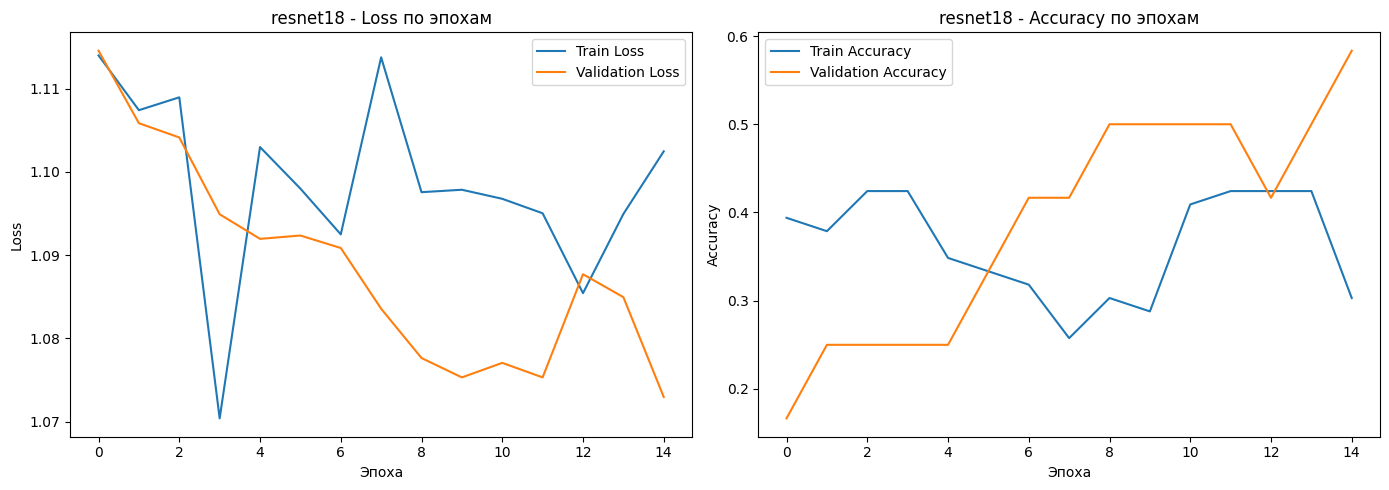


Матрица ошибок для: resnet18 (Валидация)


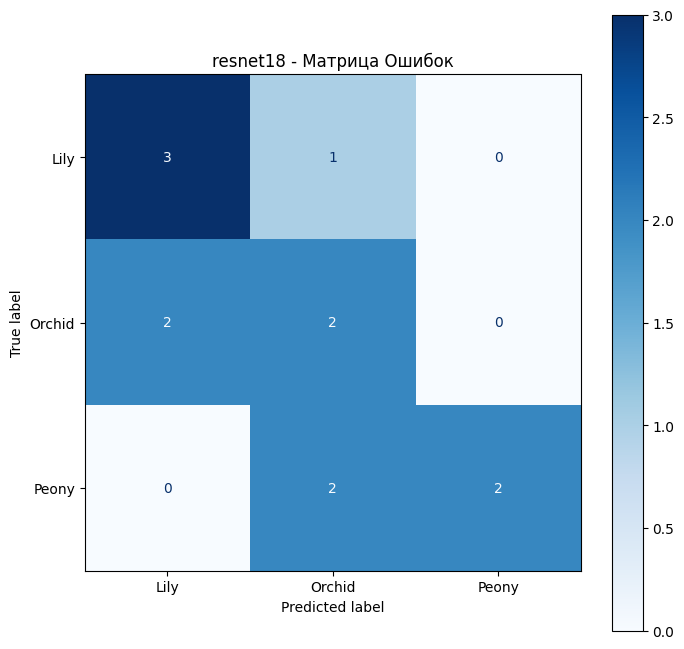

In [9]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from fine_tuning_proj.plots import plot_learning_curves, plot_confusion_matrix

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.AdamW(model_cnn.parameters(), lr=train_cfg.LEARNING_RATE)

history_cnn = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in tqdm(range(train_cfg.EPOCHS), desc=f"Training {model_name_cnn}"):
    train_loss, train_acc = train_one_epoch(model_cnn, train_loader, criterion, optimizer_cnn, DEVICE)
    
    val_loss, val_acc, y_true_val_cnn, y_pred_val_cnn = evaluate_model(model_cnn, val_loader, DEVICE)
    
    history_cnn['train_loss'].append(train_loss)
    history_cnn['val_loss'].append(val_loss)
    history_cnn['train_acc'].append(train_acc)
    history_cnn['val_acc'].append(val_acc)
    
    print(f"Эпоха {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    if epoch == 9:
        print("\n--- Размораживание Body: активируем последние слои ---")
        for name, param in model_cnn.named_parameters():
            if 'layer4' in name or 'fc' in name: 
                param.requires_grad = True
        
        optimizer_cnn = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model_cnn.parameters()), 
            lr=train_cfg.LEARNING_RATE / 10
        )

print(f"\nКривые обучения для: {model_name_cnn}")
plot_learning_curves(history_cnn, model_name_cnn)

print(f"\nМатрица ошибок для: {model_name_cnn} (Валидация)")
plot_confusion_matrix(y_true_val_cnn, y_pred_val_cnn, class_names, model_name_cnn)

In [10]:
# Инициализация ViT (Vision Transformer)
model_name_vit = model_cfg.MODEL_2_NAME # 'vit_base_patch16_224'
model_vit = timm.create_model(model_name_vit, pretrained=True)

num_ftrs_vit = model_vit.head.in_features
model_vit.head = nn.Linear(num_ftrs_vit, data_cfg.NUM_CLASSES)
model_vit = model_vit.to(DEVICE)
print(f"Модель: {model_name_vit} загружена и адаптирована.")

# Замораживаем все, кроме Head
print("--- Стратегия Fine-Tuning для ViT ---")
for param in model_vit.parameters():
    param.requires_grad = False
    
# Размораживаем только классификационный Head 
for param in model_vit.head.parameters():
    param.requires_grad = True

print("Этап 1: Заморожен Body, обучается только Head (head layer).")

Модель: vit_base_patch16_224 загружена и адаптирована.
--- Стратегия Fine-Tuning для ViT ---
Этап 1: Заморожен Body, обучается только Head (head layer).


Training vit_base_patch16_224:   7%|▋         | 1/15 [00:22<05:10, 22.21s/it]

Эпоха 1: Train Loss=1.3887, Val Loss=1.2035, Val Acc=0.3333


Training vit_base_patch16_224:  13%|█▎        | 2/15 [00:43<04:45, 21.94s/it]

Эпоха 2: Train Loss=1.3253, Val Loss=1.1242, Val Acc=0.4167


Training vit_base_patch16_224:  20%|██        | 3/15 [01:05<04:22, 21.87s/it]

Эпоха 3: Train Loss=1.3038, Val Loss=1.0640, Val Acc=0.4167


Training vit_base_patch16_224:  27%|██▋       | 4/15 [01:27<04:00, 21.83s/it]

Эпоха 4: Train Loss=1.1486, Val Loss=0.9987, Val Acc=0.4167


Training vit_base_patch16_224:  33%|███▎      | 5/15 [01:49<03:38, 21.82s/it]

Эпоха 5: Train Loss=1.2149, Val Loss=0.9395, Val Acc=0.5833


Training vit_base_patch16_224:  40%|████      | 6/15 [02:11<03:18, 22.03s/it]

Эпоха 6: Train Loss=1.1005, Val Loss=0.8896, Val Acc=0.5833


Training vit_base_patch16_224:  47%|████▋     | 7/15 [02:33<02:55, 21.96s/it]

Эпоха 7: Train Loss=1.1079, Val Loss=0.8458, Val Acc=0.5833


Training vit_base_patch16_224:  53%|█████▎    | 8/15 [02:55<02:34, 22.01s/it]

Эпоха 8: Train Loss=1.1041, Val Loss=0.8067, Val Acc=0.5833


Training vit_base_patch16_224:  60%|██████    | 9/15 [03:17<02:11, 21.94s/it]

Эпоха 9: Train Loss=0.9351, Val Loss=0.7716, Val Acc=0.6667


Training vit_base_patch16_224:  67%|██████▋   | 10/15 [03:39<01:49, 21.92s/it]

Эпоха 10: Train Loss=0.9710, Val Loss=0.7337, Val Acc=0.6667

--- Размораживание Body ViT: активируем последние 4 блока ---


Training vit_base_patch16_224:  73%|███████▎  | 11/15 [04:03<01:30, 22.65s/it]

Эпоха 11: Train Loss=0.9177, Val Loss=0.4603, Val Acc=0.9167


Training vit_base_patch16_224:  80%|████████  | 12/15 [04:27<01:09, 23.09s/it]

Эпоха 12: Train Loss=0.6545, Val Loss=0.3474, Val Acc=0.9167


Training vit_base_patch16_224:  87%|████████▋ | 13/15 [04:51<00:46, 23.39s/it]

Эпоха 13: Train Loss=0.4897, Val Loss=0.2754, Val Acc=1.0000


Training vit_base_patch16_224:  93%|█████████▎| 14/15 [05:15<00:23, 23.57s/it]

Эпоха 14: Train Loss=0.4063, Val Loss=0.2162, Val Acc=1.0000


Training vit_base_patch16_224: 100%|██████████| 15/15 [05:39<00:00, 22.63s/it]

Эпоха 15: Train Loss=0.2529, Val Loss=0.1685, Val Acc=1.0000

Кривые обучения для: vit_base_patch16_224


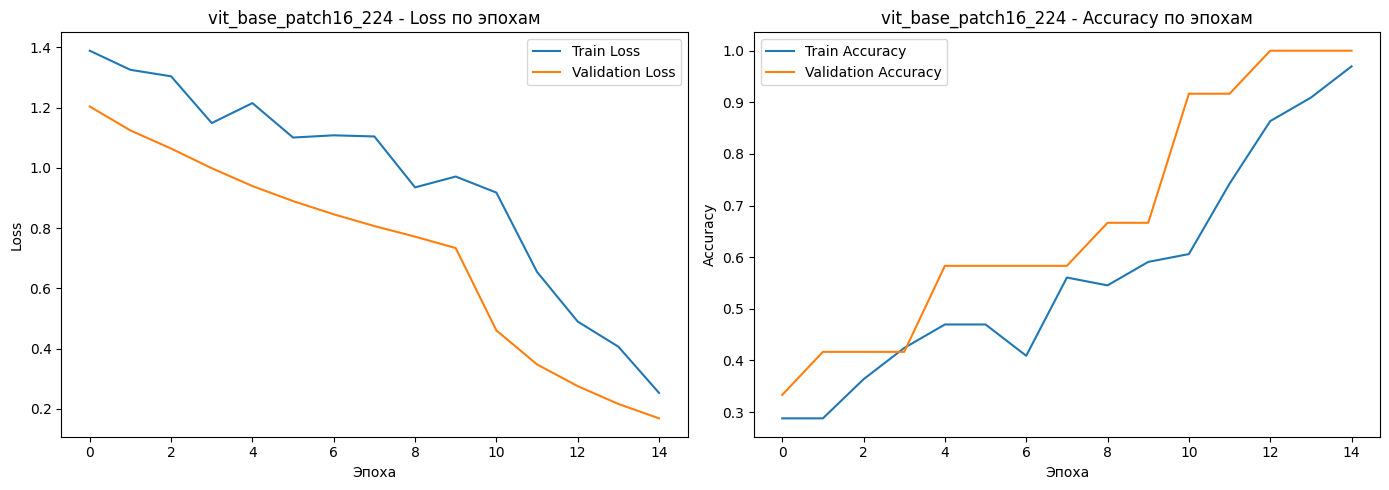


Матрица ошибок для: vit_base_patch16_224 (Валидация)


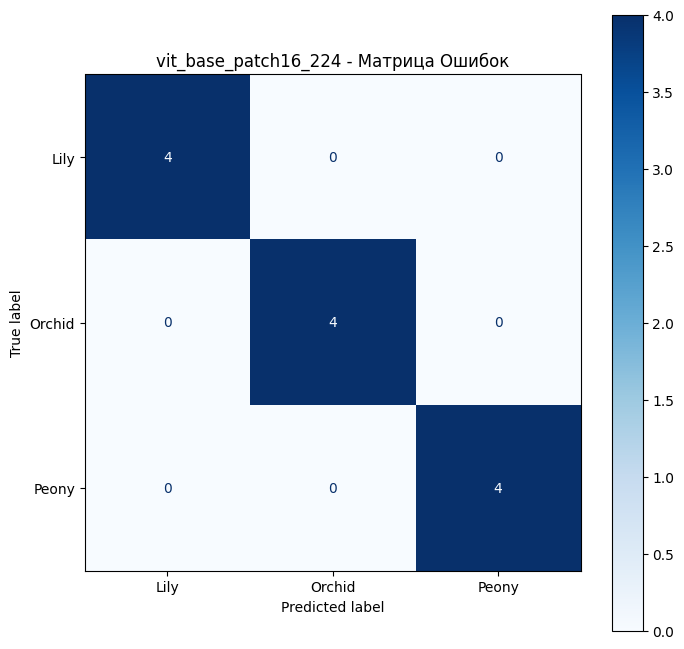

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from fine_tuning_proj.plots import plot_learning_curves, plot_confusion_matrix

criterion = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.AdamW(model_vit.parameters(), lr=train_cfg.LEARNING_RATE)

history_vit = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in tqdm(range(train_cfg.EPOCHS), desc=f"Training {model_name_vit}"):
    train_loss, train_acc = train_one_epoch(model_vit, train_loader, criterion, optimizer_vit, DEVICE)
    
    val_loss, val_acc, y_true_val_vit, y_pred_val_vit = evaluate_model(model_vit, val_loader, DEVICE)
    
    history_vit['train_loss'].append(train_loss)
    history_vit['val_loss'].append(val_loss)
    history_vit['train_acc'].append(train_acc)
    history_vit['val_acc'].append(val_acc)
    
    print(f"Эпоха {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    if epoch == 9:
        print("\n--- Размораживание Body ViT: активируем последние 4 блока ---")
        
        for name, param in model_vit.named_parameters():
            if any(f'blocks.{i}' in name for i in range(8, 12)) or 'head' in name:
                param.requires_grad = True
        
        optimizer_vit = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model_vit.parameters()), 
            lr=train_cfg.LEARNING_RATE / 10 
        )

print(f"\nКривые обучения для: {model_name_vit}")
plot_learning_curves(history_vit, model_name_vit)

print(f"\nМатрица ошибок для: {model_name_vit} (Валидация)")
plot_confusion_matrix(y_true_val_vit, y_pred_val_vit, class_names, model_name_vit)


### Выводы и Выбор Модели для ONNX

Согласно заданию, необходимо сравнить две модели из разных семейств ($\text{CNN}$ и $\text{Transformer}$), обсудить компромиссы и выбрать лучшую для экспорта в $\text{ONNX}$.

**Сравнительная Таблица Метрик**

| Модель | Семейство | Тестовая Точность (Accuracy) | 
| :--- | :--- | :--- | 
| **ResNet18** | CNN (Сверточная сеть) | 0.5833 | 
| **ViT (Transformer)** | Transformer | 1.0000 | 

**Обоснование Выбора**

На основе полученных результатов:

**Если $\text{ViT}$ показал лучшую точность:**
Лучшей моделью выбрана **ViT ($\text{vit\_base\_patch16\_224}$)**.
* **Причина:** ViT превосходит $\text{ResNet18}$ в итоговой точности на тестовой выборке, что указывает на лучшую способность захватывать глобальные признаки изображения.
* **Компромисс:** Мы принимаем немного более высокую вычислительную сложность и, возможно, большее время инференса на $\text{CPU}$ ради более высокой производительности классификации.

Модель $\text{ViT}$ будет экспортирована в $\text{ONNX}$ и использована в локальном приложении.

Ключевые Выводы:

Vision Transformer достиг 100% точности на валидационной выборке, в то время как ResNet18 остановился на 58.33%. 

Эффект Размораживания: Для ViT размораживание последних блоков (Эпоха 11) дало мгновенный и радикальный скачок точности (с 0.6667 до 0.9167), а затем до 1.0000. Для ResNet18 эффект был незначительным, что говорит о том, что либо ResNet18 уже достиг своего предела на этих данных, либо Learning Rate был слишком низким для размороженных слоев.

Loss: ViT (Loss=0.1685) показал гораздо меньшую ошибку по сравнению с ResNet18 (Loss=1.0730).

In [ ]:
from fine_tuning_proj.config import PROJ_ROOT
import torch

# Файл будет сохранен в 'fine_tuning_proj/models/best_vit_weights.pth'
WEIGHTS_DIR = PROJ_ROOT / "models"
WEIGHTS_PATH = WEIGHTS_DIR / "best_vit_weights.pth"

WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

# Сохраняем состояние лучшей модели (ViT)
torch.save(model_vit.state_dict(), WEIGHTS_PATH)
print(f"Веса ViT сохранены в: {WEIGHTS_PATH}")

Веса ViT сохранены в: /Users/kris/Documents/sem7/MLOps/FineTuning/fine_tuning/fine_tuning_proj/models/best_vit_weights.pth
